In [8]:
%matplotlib inline
import matplotlib.pylab as plt

import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
import bandicoot_dev as bc_d
import json

from build_dataset.analysis.compute_thetas import compute_thetas

In [2]:
from build_dataset.analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd

In [3]:
# Can only be loaded remotely
from build_dataset.extractors.big_five_extractor import Big_five_extractor

In [3]:
tc0 = {'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "01/01/15")
    ]
}
tc1 = {  # School weeks spring and fall 2014
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("06/01/14", "25/01/14"),
        ("03/02/14", "12/04/14"),
        ("20/04/14", "17/05/14"),
        ("02/06/14", "21/06/14"),
        ("01/09/14", "11/10/14"),
        ("19/10/14", "06/12/14")
    ]
}
tc1_spring = {  # School weeks spring 2014
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("06/01/14", "25/01/14"),
        ("03/02/14", "12/04/14"),
        ("20/04/14", "17/05/14"),
        ("02/06/14", "21/06/14"),
    ]
}
tc2 = {  # Exam weeks spring and fall 2014
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("17/05/14", "02/06/14"),
        ("06/12/14", "22/12/14")
    ]
}
tc3 = {  # Holiday weeks spring and fall 2014
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "06/01/14"),
        ("25/01/14", "03/02/14"),
        ("12/04/14", "21/04/14"),
        ("21/06/14", "01/09/14"),
        ("11/10/14", "19/10/14"),
        ("22/12/14", "31/12/14")
    ]
}

## Compute features

In [4]:
tc = "tc1_spring"

In [5]:
class SufficiencyException(Exception):
    pass

def _threshold_test(user):
    def __recs_per_day(records):
        counter = len(records) * 1.0
        span = (max(records, key=lambda r: r.datetime).datetime - \
                min(records, key=lambda r: r.datetime).datetime).days
        if span == 0:
            return 0
        return counter/span
    
    thresholds = [
        (user.text_records, 2),
        (user.call_records, 1),
        (user.physical_records, 1),
        (user.screen_records, 20),
        (user.stop_records, 1)
    ]
    
    for records, thr in thresholds:
        if __recs_per_day(records) < thr:
            return False
    return True

def _compute_features(userid, tc, groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )

    if not _threshold_test(user):
        raise SufficiencyException("User '%s' has too few records for analysis" % str(userid))
    
    user.start_time['any'] = dt.strptime('01/01/14', "%d/%m/%y")
    user.end_time['any'] = dt.strptime('01/01/15', "%d/%m/%y")
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user

def _processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def _number_of_days(groupby):
    if groupby == "week":
        return 7
    if groupby == "month":
        return 30
    if groupby == "year":
        return 365

def _get_periods(tc, groupby):
    """Only works for tc0!"""
    period = _number_of_days(groupby)
    span = tc['spans'][0]
    delta = dt.strptime(span[1], "%d/%m/%y") - \
            dt.strptime(span[0], "%d/%m/%y")
    return int(np.ceil(delta.days/period)) + 1

def _interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:,j])
        try:
            X[mask_j,j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j,j])
        except ValueError:
            X[mask_j,j] = 0
    return X

def _variance_thresholding(X):
    """Return features with below threshold variance."""
    sel = VarianceThreshold(threshold=(0.5)).fit(X)
    return sel.get_support()
    

def make_dataset(groupby="week", tc="tc0", load_cached=True, interpolate_nans=False, variance_thresholding=False, summary="special"):
    if load_cached:
        try:
            X = np.load("data/X_2014_%s_%s.pickle" % (tc, groupby))
            Y = np.load("data/Y_2014_%s.pickle" % groupby)
            M = np.load("data/M_2014_%s.pickle" % groupby)
            D = np.load("data/D_2014_%s.pickle" % groupby)
            feat_names = np.load("data/X_2014_%s_feat_names.pickle" % groupby)
            valid_users = np.load("data/XY_2014_%s_%s_valid_users.pickle" % (tc, groupby))
        except IOError:
            print "File not found. Building dataset..."
            load_cached = False
            
    if not load_cached:
        big_five = Big_five_extractor()
        users = _processed_users(tc)
        valid_users = []
        l = 0
        for u in sorted(users):  # <-- FOR LOOP START
            print "\n", u
    
            try:
                ds, user = _compute_features(u, tc=tc, groupby=groupby, summary=summary)
            except SufficiencyException as e:
                print e
                continue

            # Initiate
            if l == 0:
                if groupby == None:
                    M = len(ds)
                    N = 1
                else:
                    M = len(ds) + sum([1 for v in ds.values() if type(v[0]) is dict])  # Indicators
                    N = _get_periods(tc0, groupby)
                L = len(users)
                feat_names = []
                X = np.empty((N, M, L))
                Y = np.empty((1, 5, L))
                Q = np.empty((1, 43, L))

            U = np.full((N, M), None)

            c = 0
            for m, (f, vals) in enumerate(ds.items()):
                if l == 0:
                    if groupby != None and type(vals[0]) is dict:
                        feat_names.append(f + "_mean")
                        feat_names.append(f + "_std")
                    else:
                        feat_names.append(f)
                
                if groupby != None:
                    for n, v in enumerate(vals):
                        # v is either [int, int, int, ...], or [dict, dict, dict, ...]
                        if type(v) is dict:
                            U[n, m + c] = v['mean']
                            U[n, m + c + 1] = v['std']
                            increment_c = True
                        else:
                            U[n, m + c] = v
                            increment_c = False
                else:
                    U[0, m + c] = vals
                    increment_c = False

                if increment_c:
                    c += 1

            try:
                X[:, :, l] = U
                Y[:, :, l], Q[:, :, l] = big_five.main(u)
                valid_users.append(u)
                l+=1
            except:
                print "User", u, "skipped"

        X = X[:, :, :l]  # Not sure if it should be :l or :l+1
        Y = Y[0, :, :l]
        M = compute_thetas(Y.T, penalty='consensus')
        D = compute_thetas(Y.T, penalty='consensus', return_D=True)
        
        X.dump("data/X_2014_%s_%s.pickle" % (tc, groupby))
        Y.dump("data/Y_2014_%s.pickle" % groupby)
        M.dump("data/M_2014_%s.pickle" % groupby)
        D.dump("data/D_2014_%s.pickle" % groupby)
        np.array(feat_names).dump("data/X_2014_%s_feat_names.pickle" % groupby)
        np.array(valid_users).dump("data/XY_2014_%s_%s_valid_users.pickle" % (tc, groupby))
        
    if interpolate_nans:
        for l in range(X.shape[2]):
            mask_i = ~np.all(np.isnan(X[:, :, l]) | np.equal(X[:, :, l], 0), axis=1)
            X[mask_i, :, l] = _interpolate_nans(X[mask_i, :, l])
            
    if variance_thresholding:
        support = _variance_thresholding(scale(np.nanmean(X, axis=2)))
        X = X[:, support, :]
        print "Removed %d traits:" % np.sum(~support)
        for r in feat_names[~support]:
            print "  * %d - %s" % (list(feat_names).index(r), r)
        feat_names = feat_names[support]

    return X, Y, M, D, list(feat_names), list(valid_users)

print dt.now()
Xo, Yo, Mo, Do, feat_nameso, valid_userso = make_dataset(groupby=None, tc=tc, summary="default", load_cached=True, interpolate_nans=True, variance_thresholding=False)

2016-06-12 22:03:35.048229


In [ ]:
# Build into pipeline later!
Q = np.empty((1, 43, len(valid_userso)))
big_five = Big_five_extractor()
for l, u in enumerate(valid_userso):
    _, Q[:, :, l] = big_five.main(u)

In [46]:
Q = Q[0, :, :].T

In [26]:
# SET NAMES TO REFLECT REVERSE MEANING !!!

feature_name_map = {
    "percent_at_campus_stop": "Spends time at campus", 
    "percent_concluded_conversations_text_mean": "Concludes text conversations", 
    "number_of_contacts_text+call": "Has many phone contacts",
    "number_of_contacts_less_physical": "Interacts with strangers", 
    "response_delay_text_mean": "Responds quickly to texts",  # reversed
    "response_rate_text+call_mean": "Returns calls and responds to texts", 
    "percent_initiated_conversations_call_std": "Calls some people more than others", 
    "response_delay_call_std": "Response time to missed calls depends on receiver", 
    "percent_nocturnal_screen": "Uses phone at night", 
    "number_of_contacts_less_stop": "Visits many places only once", 
    "percent_nocturnal_physical": "Meets people at night", 
    "duration_call": "Makes long calls", 
    "duration_physical": "Spends long time with people", 
    "number_of_interactions_text+call": "Frequently calls and texts", 
    "duration_stop": "Spends short time at locations",  # reversed
    "percent_initiated_conversations_text_std": "Conversation initiation rate depends on receiver", 
    "percent_outside_campus_from_campus_physical+stop": "Meets people from school outside of school", 
    "number_of_interactions_physical": "Around people a lot", 
    "response_delay_text_std": "Response time to texts depends on receiver", 
    "percent_concluded_conversations_text_std": "Getting final word when texting depends on receiver", 
    "duration_screen": "Keeps phone sessions short",  # reversed
    "percent_ei_percent_durations_stop": "Distributes time at different locations evenly", 
    "ratio_call_text_text+call": "Prefers calling over texting", 
    "duration_text": "Has long ongoing text conversations", 
    "first_seen_response_rate_text+screen": "Responds to texts immediately", 
    "overlap_conversations_physical": "Mostly goes in groups", 
    "percent_initiated_conversations_text_mean": "Initiates most text conversations", 
    "ratio_social_screen_alone_screen_physical+screen": "Avoids looking at phone when social",  # reversed
    "number_of_contacts_stop": "Visits many different places", 
    "interevent_time_screen": "Doesnt look at phone too often",  
    "number_of_interactions_stop": "Goes places often", 
    "response_rate_text+call_std": "Selective text and call response rate", 
    "percent_nocturnal_stop": "Goes many places at night", 
    "percent_initiated_conversations_call_mean": "Initiates most phone conversations", 
    "interaction_autocorrelation_physical": "Meets with people in weekly patterns", 
    "ratio_interactions_campus_other_physical+stop": "Mostly meets people at campus", 
    "balance_of_interactions_text": "Sends more texts than receives", 
    "response_delay_call_mean": "Responds quickly to missed calls"  # reversed
}

super_traits = {
    'number_of_contacts_stop': [('j_mobility', 1)],
    'number_of_contacts_text+call': [('a_social_scale', 1)],
    'number_of_interactions_stop': [('j_mobility', 1)],
    'number_of_interactions_text+call': [('b_social_engagement', 1)],
    'number_of_interactions_physical': [('b_social_engagement', 1)],
    'percent_ei_percent_durations_stop': [('j_mobility', 1)],
    'balance_of_interactions_text': [('c_social_control', 1)],
    'duration_stop': [('j_mobility', -1)],  # reversed
    'duration_text': [('b_social_engagement', 1)],
    'duration_screen': [('k_phone_independency', -1)],  # reversed
    'duration_call': [('b_social_engagement', 1)],
    'duration_physical': [('b_social_engagement', 1)],
    'percent_initiated_conversations_text_std': [('c_social_control', 1)],
    'percent_initiated_conversations_text_mean': [('c_social_control', 1)],
    'percent_initiated_conversations_call_std': [('c_social_control', 1)],
    'percent_initiated_conversations_call_mean': [('c_social_control', 1)],
    'percent_concluded_conversations_text_std': [('c_social_control', 1)],
    'percent_concluded_conversations_text_mean': [('c_social_control', 1)],
    'overlap_conversations_physical': [('f_social_gregariousness', 1)],
    'response_delay_text_std': [('c_social_control', 1)],
    'response_delay_text_mean': [('d_social_responsiveness', -1)],  # reversed
    'response_delay_call_std': [('c_social_control', 1)],
    'response_delay_call_mean': [('d_social_responsiveness', -1)],  # reversed
    'response_rate_text+call_std': [('c_social_control', 1)],
    'response_rate_text+call_mean': [('d_social_responsiveness', 1)],
    'percent_nocturnal_screen': [('l_nocturnality', 1)],
    'percent_nocturnal_stop': [('l_nocturnality', 1)],
    'percent_nocturnal_physical': [('l_nocturnality', 1)],
    'interevent_time_screen': [('k_phone_independency', 1)],
    'ratio_social_screen_alone_screen_physical+screen': [('b_social_engagement', -1)],  # reversed
    'ratio_interactions_campus_other_physical+stop': [('g_social_engagement_uni', 1)],
    'percent_outside_campus_from_campus_physical+stop': [('g_social_engagement_uni', 1)],
    'percent_at_campus_stop': [('h_engagement_uni', 1)],
    'number_of_contacts_less_stop': [('i_adventurousness', 1)],
    'number_of_contacts_less_physical': [('i_adventurousness', 1)],
    'first_seen_response_rate_text+screen': [('d_social_responsiveness', 1)],
    'ratio_call_text_text+call': [('e_social_directness', 1)],
    'interaction_autocorrelation_physical': [('h_engagement_uni', 1)]
}

trait_sign = {
    'number_of_contacts_text+call': 1,
    'duration_text': 1,
    'ratio_social_screen_alone_screen_physical+screen': -1,
    'duration_call': 1,
    'duration_physical': 1,
    'number_of_interactions_text+call': 1,
    'number_of_interactions_physical': 1,
    'percent_concluded_conversations_text_mean': 1,
    'response_delay_text_std': 1,
    'response_delay_call_std': 1,
    'percent_initiated_conversations_text_mean': 1,
    'response_rate_text+call_std': 1,
    'percent_initiated_conversations_call_mean': 1,
    'balance_of_interactions_text': 1,
    'percent_initiated_conversations_text_std': 1,
    'percent_initiated_conversations_call_std': 1,
    'percent_concluded_conversations_text_std': 1,
    'response_delay_call_mean': -1,
    'response_delay_text_mean': -1,
    'response_rate_text+call_mean': 1,
    'first_seen_response_rate_text+screen': 1,
    'ratio_call_text_text+call': 1,
    'overlap_conversations_physical': 1,
    'percent_outside_campus_from_campus_physical+stop': 1,
    'ratio_interactions_campus_other_physical+stop': 1,
    'percent_at_campus_stop': 1,
    'interaction_autocorrelation_physical': 1,
    'number_of_contacts_less_physical': 1,
    'number_of_contacts_less_stop': 1,
    'percent_ei_percent_durations_stop': 1,
    'number_of_contacts_stop': 1,
    'number_of_interactions_stop': 1,
    'duration_stop': -1,
    'duration_screen': -1,
    'interevent_time_screen': 1,
    'percent_nocturnal_physical': 1,
    'percent_nocturnal_screen': 1,
    'percent_nocturnal_stop': 1
}

# Save to globals
with open('globals/feature_name_map.json', 'w') as outfile:
    json.dump(feature_name_map, outfile)
with open('globals/super_traits.json', 'w') as outfile:
    json.dump(super_traits, outfile)
with open('globals/trait_sign.json', 'w') as outfile:
    json.dump(trait_sign, outfile)

### Clean feature names and sort features by supertraits

In [27]:
# CLEAN
def cl(f):
    return '_'.join(('_'.join(f.split("__allweek__allday__"))).split("__"))

def cp(f):
    return ' '.join([w.capitalize() for w in f.split('_')])

non_informative = []
feat_names = [cl(f) for f in feat_nameso if cl(f) not in non_informative]
with open('data/X_2014_%s_feat_names.csv' % str(None), 'w') as outfile:
    outfile.write(', '.join(feat_names))

# SORT
feat_names_sorted = []
new_order = []
for supertr in sorted(set([st[0] for stl in super_traits.values() for st in stl])):
    print cp(supertr[2:])
    for k, v in super_traits.items():
        if supertr in [i[0] for i in v]:
            print "\t", k
            feat_names_sorted.append(k)
            new_order.append(feat_names.index(k))
    print

feat_names = feat_names_sorted

Social Scale
	number_of_contacts_text+call

Social Engagement
	duration_text
	ratio_social_screen_alone_screen_physical+screen
	duration_call
	duration_physical
	number_of_interactions_text+call
	number_of_interactions_physical

Social Control
	percent_concluded_conversations_text_mean
	response_delay_text_std
	response_delay_call_std
	percent_initiated_conversations_text_mean
	response_rate_text+call_std
	percent_initiated_conversations_call_mean
	balance_of_interactions_text
	percent_initiated_conversations_text_std
	percent_initiated_conversations_call_std
	percent_concluded_conversations_text_std

Social Responsiveness
	response_delay_call_mean
	response_delay_text_mean
	response_rate_text+call_mean
	first_seen_response_rate_text+screen

Social Directness
	ratio_call_text_text+call

Social Gregariousness
	overlap_conversations_physical

Social Engagement Uni
	percent_outside_campus_from_campus_physical+stop
	ratio_interactions_campus_other_physical+stop

Engagement Uni
	percent_at_

### Apply column variable transforms

In [28]:
def print_untransformed():
    for i, n in enumerate(feat_names):
        if n not in tr_scheme:
            print(i, n)

#print_untransformed()

# Also apply column reordering!
X = Xo[0, new_order, :].T  # Change shape (1, n, m)  -->  (n, m)

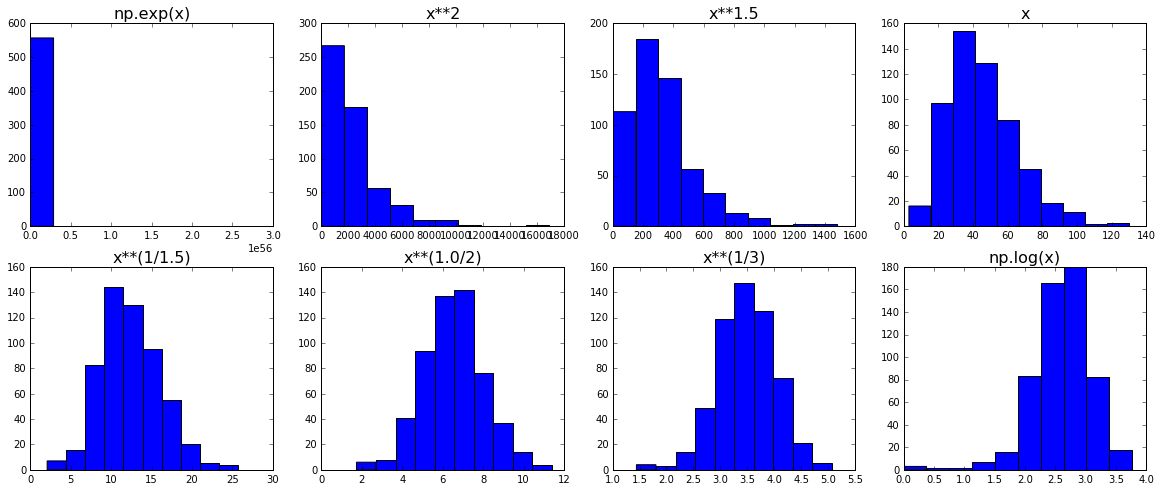

(0, 'number_of_contacts_text+call', '-', 'Has many phone contacts')


In [29]:
transforms = [
    (lambda x: np.exp(x), "np.exp(x)"),
    (lambda x: x**2, "x**2"),
    (lambda x: x**1.5, "x**1.5"),
    (lambda x: x, "x"),
    (lambda x: x**(1/1.5), "x**(1/1.5)"),
    (lambda x: x**(1.0/2), "x**(1.0/2)"),
    (lambda x: x**(1/3.0), "x**(1/3)"),
    (lambda x: np.log(x+0.01) - min(np.log(x+0.01)), "np.log(x)")
]

col_id = 0  # <-- CHOOSE FEATURE ID TO TEST
c = 0
plt.figure(figsize=(20, 8))
for t, s in transforms:
    try:
        tr = t(X[:, col_id])
        if tr[tr<0].any(0):
            print("Warning: transform contains neg. value")
            continue
        if tr[tr==np.inf].any(0):
            print("Warning: transform contains inf. value")
            continue
        c += 1
    except:
        pass
    plt.subplot(2, 4, c)
    plt.title(s, fontsize=16)
    plt.hist(tr)
    
plt.show()

print(col_id, cl(feat_names[col_id]), "-", feature_name_map[cl(feat_names[col_id])])

In [30]:
tr_scheme = {
    'number_of_contacts_stop': lambda x: x,  # √
    #'number_of_contacts_text': lambda x: np.log(x),
    #'number_of_contacts_call': lambda x: np.log(x),
    'number_of_contacts_text+call': lambda x: np.log(x),  # √
    #'number_of_contacts_physical': lambda x: x,
    'number_of_interactions_stop': lambda x: x,  # √
    #'number_of_interactions_text': lambda x: np.log(x),
    #'number_of_interactions_call': lambda x: np.log(x),
    'number_of_interactions_text+call': lambda x: np.log(x),  # √
    'number_of_interactions_physical': lambda x: np.log(x),  # √
    #'interactions_per_contact_stop': lambda x: np.log(x),
    #'interactions_per_contact_text': lambda x: np.log(x),
    #'interactions_per_contact_call': lambda x: np.log(x),
    #'interactions_per_contact_physical': lambda x: np.log(x),
    'ratio_call_text_text+call': lambda x: np.log(x),  # √
    #'percent_ei_percent_interactions_text': lambda x: np.log(x),
    #'percent_ei_percent_interactions_physical': lambda x: np.log(x),
    'balance_of_interactions_text': lambda x: x,  # √
    #'balance_of_interactions_call': lambda x: x,
    #'entropy_per_contacts_stop': lambda x: x,
    #'entropy_per_contacts_text': lambda x: np.exp(x),
    #'entropy_per_contacts_call': lambda x: np.exp(x),
    #'entropy_per_contacts_physical': lambda x: np.exp(x),
    'duration_stop': lambda x: np.log(x),  # √
    'duration_text': lambda x: x,  # √
    'duration_screen': lambda x: np.log(x),  # √
    'duration_call': lambda x: np.log(x),  # √
    'duration_physical': lambda x: x,  # √
    'percent_ei_percent_durations_stop': lambda x: np.log(x),  # √
    #'percent_ei_percent_durations_call': lambda x: x,
    'percent_initiated_conversations_text_std': lambda x: x,  # √
    'percent_initiated_conversations_text_mean': lambda x: x,  # √
    'percent_initiated_conversations_call_std': lambda x: x,  # √
    'percent_initiated_conversations_call_mean': lambda x: x,  # √
    'percent_concluded_conversations_text_std': lambda x: x,  # √
    'percent_concluded_conversations_text_mean': lambda x: x,  # √
    'percent_concluded_conversations_call_std': lambda x: x,  # √
    'percent_concluded_conversations_call_mean': lambda x: x,  # √
    #'percent_initiated_conversations_text+call_std': lambda x: x,
    #'percent_initiated_conversations_text+call_mean': lambda x: x,
    #'percent_concluded_conversations_text+call_std': lambda x: x,
    #'percent_concluded_conversations_text+call_mean': lambda x: x,
    #'overlap_conversations_per_contacts_text': lambda x: np.log(x+0.0001),
    #'overlap_conversations_per_contacts_physical': lambda x: np.log(x+0.0001),
    'overlap_conversations_physical': lambda x: x,
    'response_delay_text_std': lambda x: x,  # √
    'response_delay_text_mean': lambda x: x,  # √
    'response_delay_call_std': lambda x: x,  # √
    'response_delay_call_mean': lambda x: x,  # √
    'response_rate_text+call_std': lambda x: x,  # √
    'response_rate_text+call_mean': lambda x: x,  # √
    'percent_nocturnal_screen': lambda x: x,  # √
    'percent_nocturnal_stop': lambda x: np.log(x),  # √
    'percent_nocturnal_physical': lambda x: np.log(x+0.01),  # √
    'interevent_time_screen': lambda x: np.log(x),  # √
    'ratio_social_screen_alone_screen_physical+screen': lambda x: np.log(x),  # √
    #'percent_interactions_campus_physical+stop': lambda x: x,
    'ratio_interactions_campus_other_physical+stop': lambda x: -np.log(1-x),  # √
    #'percent_interactions_home_physical+stop': lambda x: np.log(x+0.01),
    #'percent_interactions_other_physical+stop': lambda x: np.log(x),
    'percent_outside_campus_from_campus_physical+stop': lambda x: x**(1/2.0),  # √
    'percent_at_campus_stop': lambda x: x,  # √
    #'percent_at_home_stop': lambda x: x,
    #'percent_at_friday_bar_stop': lambda x: np.log(x+0.00001),
    'percent_contacts_less_stop': lambda x: x,  # √
    'percent_contacts_less_physical': lambda x: x,  # √
    'first_seen_response_rate_text+screen': lambda x: x,  # √
    'interaction_autocorrelation_physical': lambda x: x**(1/2.0),
    'number_of_contacts_less_stop': lambda x: x,
    'number_of_contacts_less_physical': lambda x: np.sqrt(x)
}

fi_scheme = {
    'number_of_contacts_stop': lambda x: x > 0,
    'number_of_contacts_text': lambda x: x > 0,
    'number_of_contacts_call': lambda x: x > 0,
    'number_of_contacts_text+call': lambda x: x > 0,
    'number_of_contacts_physical': lambda x: x > 0,
    'number_of_interactions_stop': lambda x: x > 0,
    'number_of_interactions_text': lambda x: x > 0,
    'number_of_interactions_call': lambda x: x > 0,
    'number_of_interactions_text+call': lambda x: x > 10,
    'number_of_interactions_physical': lambda x: x >= 5,
    'interactions_per_contact_stop': lambda x: x >= 0,
    'interactions_per_contact_text': lambda x: x >= 0,
    'interactions_per_contact_call': lambda x: x >= 0,
    'interactions_per_contact_physical': lambda x: x >= 0,
    'percent_ei_percent_interactions_text': lambda x: x >= 0,
    'percent_ei_percent_interactions_physical': lambda x: x >= 0,
    'balance_of_interactions_text': lambda x: x >= 0,
    'balance_of_interactions_call': lambda x: x >= 0,
    'entropy_per_contacts_stop': lambda x: x >= 0,
    'entropy_per_contacts_text': lambda x: x >= 0,
    'entropy_per_contacts_call': lambda x: x >= 0,
    'entropy_per_contacts_physical': lambda x: x >= 0,
    'duration_stop': lambda x: x < 60000,
    'duration_text': lambda x: x >= 0,
    'duration_screen': lambda x: x >= 0,
    'duration_call': lambda x: x >= 0,
    'duration_physical': lambda x: x >= 0,
    'percent_ei_percent_durations_stop': lambda x: x >= 0,
    'percent_ei_percent_durations_call': lambda x: x >= 0,
    'percent_initiated_conversations_text_std': lambda x: x >= 0.1,
    'percent_initiated_conversations_text_mean': lambda x: x >= 0,
    'percent_initiated_conversations_call_std': lambda x: x >= 0,
    'percent_initiated_conversations_call_mean': lambda x: x >= 0,
    'percent_concluded_conversations_text_std': lambda x: x >= 0.1,
    'percent_concluded_conversations_text_mean': lambda x: x >= 0,
    'percent_concluded_conversations_call_std': lambda x: x >= 0,
    'percent_concluded_conversations_call_mean': lambda x: x >= 0,
    'percent_initiated_conversations_text+call_std': lambda x: x >= 0,
    'percent_initiated_conversations_text+call_mean': lambda x: x >= 0,
    'percent_concluded_conversations_text+call_std': lambda x: x >= 0,
    'percent_concluded_conversations_text+call_mean': lambda x: x >= 0,
    'overlap_conversations_physical': lambda x: x >= 0,
    'response_delay_text_std': lambda x: x > 0,
    'response_delay_text_mean': lambda x: x > 0,
    'response_delay_call_std': lambda x: x > 0,  # x > 0
    'response_delay_call_mean': lambda x: x > 5,  # x > 5
    'response_rate_text+call_std': lambda x: x >= 0.2,
    'response_rate_text+call_mean': lambda x: x >= 0,
    'percent_nocturnal_screen': lambda x: x >= 0,
    'percent_nocturnal_stop': lambda x: x >= 0,
    'percent_nocturnal_physical': lambda x: x >= 0,
    'interevent_time_screen': lambda x: x >= 0,
    'fraction_social_screen_alone_screen_screen+physical': lambda x: x >= 0,
    'percent_interactions_campus_physical+stop': lambda x: x >= 0,
    'percent_interactions_home_physical+stop': lambda x: x >= 0,
    'percent_interactions_other_physical+stop': lambda x: x >= 0,
    'percent_outside_campus_from_campus_physical+stop': lambda x: x >= 0,
    'percent_at_campus_stop': lambda x: x > 0,  # normally x > 0
    'percent_at_home_stop': lambda x: x > 0.2,
    'percent_at_friday_bar_stop': lambda x: x >= 0,
    'percent_contacts_less_stop': lambda x: x >= 0,
    'percent_contacts_less_physical': lambda x: x >= 0,
    'first_seen_response_rate_screen+text': lambda x: x >= 0,
    'ratio_social_screen_alone_screen_physical+screen': lambda x: x >= 0,
    'ratio_interactions_campus_other_physical+stop': lambda x: x >= 0,
    'number_of_contacts_less_stop': lambda x: x >= 0,
    'number_of_contacts_less_physical': lambda x: x > 0,
    'first_seen_response_rate_text+screen': lambda x: x >= 0,
    'ratio_call_text_text+call': lambda x: x >= 0,
    'interaction_autocorrelation_physical': lambda x: x > 0
}

### Filter crude outliers and apply transformations

In [31]:
outliers = set()

Xt = X.copy()
for i in range(Xt.shape[0]):
    for j, n in enumerate(feat_names):
        if not fi_scheme[n](Xt[i, j]):
            outliers.add(i)
            print i, n
            
Xt = np.delete(Xt, list(outliers), axis=0)
Y = np.delete(Yo.T, list(outliers), axis=0)
#Q = np.delete(Q, list(outliers), axis=0)
M = np.delete(Mo, list(outliers), axis=0)
D = np.delete(Do, list(outliers), axis=0)

for j, n in enumerate(feat_names):
    try:
        tr = tr_scheme[n]
    except KeyError:
        print "KeyError:", n, "not in tr_scheme. It should be... fix this. Using untransformed variable."
    Xt[:, j] = tr(Xt[:, j])

1 response_delay_call_std
7 percent_at_campus_stop
15 response_delay_call_std
18 number_of_interactions_physical
18 percent_at_campus_stop
25 response_delay_call_std
40 response_delay_call_std
42 response_delay_call_std
42 duration_stop
46 percent_at_campus_stop
51 response_delay_call_std
55 response_delay_call_std
66 duration_stop
79 response_delay_call_std
81 response_delay_call_std
87 response_delay_call_std
93 response_delay_call_std
102 response_delay_call_std
106 response_delay_call_std
110 interaction_autocorrelation_physical
130 response_delay_call_std
146 response_delay_call_std
147 response_delay_call_std
148 response_delay_call_std
148 response_delay_call_mean
156 response_delay_call_std
174 response_delay_call_std
176 response_delay_call_std
187 response_delay_call_std
195 percent_at_campus_stop
199 response_delay_call_std
205 response_delay_call_std
220 response_delay_call_std
220 response_delay_call_mean
227 interaction_autocorrelation_physical
232 response_delay_call_std

### ZScore, apply sign transform
Flip sign of some features to clear up interpretation

In [32]:
Xtz = scale(Xt[~np.isnan(Xt).any(axis=1)])

tr = np.array([trait_sign[n] for n in feat_names]).reshape((1, -1))
Xtz = Xtz * tr

np.savetxt("data/Xtz_%s.csv" % tc, Xtz, delimiter=",")
np.savetxt("data/Y_%s.csv" % tc, Y, delimiter=",")
#np.savetxt("data/Q_%s.csv" % tc, Q, delimiter=",")
np.savetxt("data/M_%s.csv" % tc, M, delimiter=",")
np.savetxt("data/D_%s.csv" % tc, D, delimiter=",")

### Detect outliers

In [33]:
# Find outliers using KD and SVM
outliers_svm = Outlier_detector_svm(Xtz, hard=False, threshold=0, visualize=False, nu=0.1, gamma=0.25).main()
outliers_kd = Outlier_detector_kd(Xtz, visualize=False, threshold=0.07, bandwidth=2, kernel='gaussian').main()

# Remove outliers SVM
Xtz_clean_svm = scale(np.delete(Xtz, outliers_svm, axis=0))
Y_clean_svm = np.delete(Y, outliers_svm, axis=0)
#Q_clean_svm = np.delete(Q, outliers_svm, axis=0)
M_clean_svm = np.delete(M, outliers_svm, axis=0)
D_clean_svm = np.delete(D, outliers_svm, axis=0)

# Remove outliers KD
Xtz_clean_kd = scale(np.delete(Xtz, outliers_kd, axis=0))
Y_clean_kd = np.delete(Y, outliers_kd, axis=0)
#Q_clean_kd = np.delete(Q, outliers_kd, axis=0)
M_clean_kd = np.delete(M, outliers_kd, axis=0)
D_clean_kd = np.delete(D, outliers_kd, axis=0)

# Save clean datasets SVM
print "[svm] Removed %d outliers, clean subset has %d samples" % (
    (Xtz.shape[0]-Xtz_clean_svm.shape[0]), Xtz_clean_svm.shape[0])
np.savetxt("data/Xtz_%s_clean_svm.csv" % tc, Xtz_clean_svm, delimiter=",")
np.savetxt("data/Y_%s_clean_svm.csv" % tc, Y_clean_svm, delimiter=",")
#np.savetxt("data/Q_%s_clean_svm.csv" % tc, Q_clean_svm, delimiter=",")
np.savetxt("data/M_%s_clean_svm.csv" % tc, M_clean_svm, delimiter=",")
np.savetxt("data/D_%s_clean_svm.csv" % tc, D_clean_svm, delimiter=",")
np.savetxt("data/XtzYM_%s_clean_svm_valid_users.csv" % tc, np.array(sorted(set(valid_userso) - set(outliers_svm))), delimiter=",")

# Save clean datasets KD
print "[kd] Removed %d outliers, clean subset has %d samples" % (
    (Xtz.shape[0]-Xtz_clean_kd.shape[0]), Xtz_clean_kd.shape[0])
np.savetxt("data/Xtz_%s_clean_kd.csv" % tc, Xtz_clean_kd, delimiter=",")
np.savetxt("data/Y_%s_clean_kd.csv" % tc, Y_clean_kd, delimiter=",")
#np.savetxt("data/Q_%s_clean_kd.csv" % tc, Q_clean_kd, delimiter=",")
np.savetxt("data/M_%s_clean_kd.csv" % tc, M_clean_kd, delimiter=",")
np.savetxt("data/D_%s_clean_kd.csv" % tc, D_clean_kd, delimiter=",")
np.savetxt("data/XtzYM_%s_clean_kd_valid_users.csv" % tc, np.array(sorted(set(valid_userso) - set(e[0] for e in outliers_kd))), delimiter=",")

np.array(feat_names).dump("data/X_2014_%s_feat_names_sorted.pickle" % None)

[svm] Removed 36 outliers, clean subset has 406 samples
[kd] Removed 30 outliers, clean subset has 412 samples


/Users/ulfaslak/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4299: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  "`numpy.delete`.", FutureWarning)
